# CAN Workshop- LFADS demo in pytorch

## Import necessary modules

In [1]:
%matplotlib inline

import torch
import torchvision
#np = torch._np
import numpy as np
import matplotlib.pyplot as plt

import os
import yaml
import math
from lfads_sim import LFADS_Net
from utils import read_data, load_parameters, save_parameters
import scipy.io
# plt.style.use('dark_background')
import shutil
path = './models_sim'
if os.path.isdir(path): 
    shutil.rmtree(path)

In [2]:
# Select device to train LFADS on
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cpu


## Load or Generate Data 

In [3]:
all_time =2500
start_time = 0
Time = 20
neuron_num = 30
datax = scipy.io.loadmat("spike30_sim_3000.mat")
y_data = datax["spike30_sim_3000"][start_time:all_time,:]
traj = scipy.io.loadmat("trj30_sim_3000.mat")
traj = traj["trj30_sim_3000"][start_time:all_time,:]
NRep=int((all_time-start_time)/Time)
output = np.zeros((NRep,Time,neuron_num))
print(y_data.shape)
#for i in range(all_time-start_time):
#    for j in range(neuron_num):
#        if y_data[i][j] > 20:
#            y_data[i][j] = 20
for i in range(NRep):
    output[i,:,:] = y_data[Time*i:Time*(i+1),:]
output = output.astype('float32')
output = torch.Tensor(output).to(device)
print(output.shape)
output_valid = output.detach().clone()

(2500, 30)
torch.Size([125, 20, 30])


## View example Ground Truth Firing Rates

(20, 30)


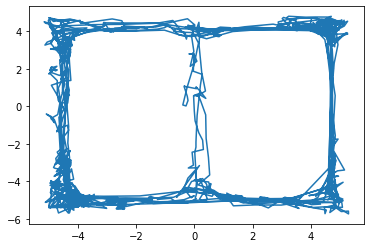

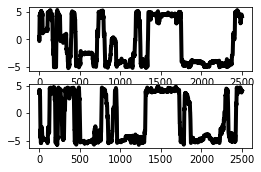

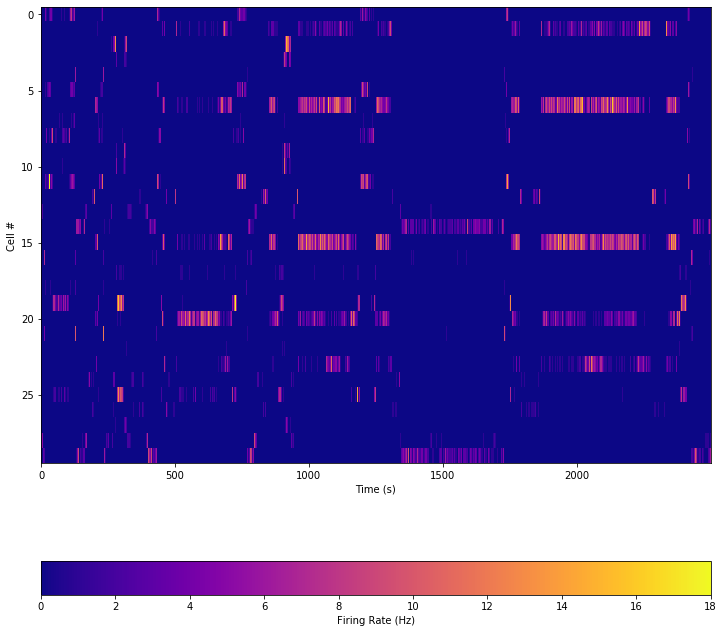

In [4]:
train_ds      = torch.utils.data.TensorDataset(output)
valid_ds      = torch.utils.data.TensorDataset(output)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[:,0],traj[:,1])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)
print(output[0].shape)
plt.figure(figsize = (12,12))
plt.imshow(y_data.T, cmap=plt.cm.plasma,aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='Firing Rate (Hz)')

In [5]:
#for i in range(neuron_num):
    #fig, ax = plt.subplots()
    #mappable = ax.scatter(traj[:,0], traj[:,1], c=y_data[:,i] ,cmap='coolwarm',vmin=0,vmax=8)
    #fig.colorbar(mappable)
    #plt.title(i)
    #plt.show()
#fig.savefig("img.png")

## LFADS Schema
<img src='lfads_schema.png' width=800 align=left>

## Load model hyperparameters 

In [6]:
hyperparams = load_parameters('./parameters_sim.yaml')
save_parameters(hyperparams)
hyperparams

C:\Users\flab\prog\lfads_torch_k09\utils.py:91: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(open(path))


{'dataset_name': 'chaotic_rnn',
 'run_name': 'demo',
 'g_dim': 30,
 'u_dim': 30,
 'factors_dim': 2,
 'g0_encoder_dim': 30,
 'c_encoder_dim': 30,
 'controller_dim': 30,
 'g0_prior_kappa': 0.1,
 'u_prior_kappa': 0.1,
 'keep_prob': 0.95,
 'clip_val': 5.0,
 'max_norm': 200,
 'learning_rate': 0.01,
 'learning_rate_min': 1e-05,
 'learning_rate_decay': 0.9,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'scheduler_cooldown': 6,
 'kl_weight_schedule_start': 0,
 'kl_weight_schedule_dur': 2000,
 'l2_weight_schedule_start': 0,
 'l2_weight_schedule_dur': 2000,
 'epsilon': 0.1,
 'betas': (0.9, 0.99),
 'l2_gen_scale': 2000,
 'l2_con_scale': 0}

## Instantiate LFADS model

In [7]:
model = LFADS_Net(inputs_dim = neuron_num, T = Time, dt = 1, device=device,
                 model_hyperparams=hyperparams).to(device)

Random seed: 1351


#### Pick up where you left off (if you have a recent save) 

In [8]:
# model.load_checkpoint('recent')
batch_size = 2
"""tt = np.empty((3000,2))
for k in range(10):
    t = model.infer_trj(output_valid[batch_size *k:batch_size *(k+1),:])
    #print(t[90].shape)
    for i in range(batch_size):
        for j in range(100):
            tt[k*100*i+j,:]=t[j][i].to('cpu').detach().numpy().copy()
plt.figure()
plt.plot(tt)"""

"tt = np.empty((3000,2))\nfor k in range(10):\n    t = model.infer_trj(output_valid[batch_size *k:batch_size *(k+1),:])\n    #print(t[90].shape)\n    for i in range(batch_size):\n        for j in range(100):\n            tt[k*100*i+j,:]=t[j][i].to('cpu').detach().numpy().copy()\nplt.figure()\nplt.plot(tt)"

## Fit model

Rule of thumb: You can usually see good fit after 200 epochs (~30 mins runtime on Thinkpad GPU, ~2.5 hours on CPU), but to see good inference of perturbation timings need to run for about 800 epochs (~2 hours on Thinkpad GPU).

In [9]:
model.fit(train_ds, valid_ds, max_epochs=200, batch_size=batch_size , use_tensorboard=False,
          train_truth=train_ds, valid_truth=valid_ds)

Beginning training...
Epoch:    1, Step:    63, training loss: 544.683
recon:  340, kl:    14, dir:    0, klf:    0, klw:    0
Epoch:    2, Step:   126, training loss: 375.933
recon:  325, kl:    10, dir:    0, klf:    1, klw:    0
Epoch:    3, Step:   189, training loss: 316.038
recon:  239, kl:    14, dir:    0, klf:    7, klw:    0
Epoch:    4, Step:   252, training loss: 288.009
recon:  104, kl:    23, dir:    0, klf:    1, klw:    0
Epoch:    5, Step:   315, training loss: 294.861
recon:  497, kl:    43, dir:    0, klf: 3826094, klw:    0
Epoch:    6, Step:   378, training loss: 278.947
recon:  102, kl:    18, dir:    0, klf:   27, klw:    0
Epoch:    7, Step:   441, training loss: 291.474
recon:  125, kl:    16, dir:    0, klf:   97, klw:    0
Epoch:    8, Step:   504, training loss: 272.390
recon:   82, kl:    25, dir:    0, klf: 58817, klw:    0
Epoch:    9, Step:   567, training loss: 281.474
recon:  261, kl:    25, dir:    0, klf:   33, klw:    0
Epoch:   10, Step:   630, tra

Epoch:   71, Step:  4473, training loss: 247.404
recon:   70, kl:    10, dir:    0, klf: 34904977408, klw:    1
Epoch:   72, Step:  4536, training loss: 242.878
recon:  225, kl:    19, dir:    0, klf: 4240330170678508519424, klw:    1
Epoch:   73, Step:  4599, training loss: 245.123
recon:  211, kl:    29, dir:    0, klf: 561628076572672, klw:    1
Epoch:   74, Step:  4662, training loss: 242.308
recon:  196, kl:    24, dir:    0, klf: 59741459336419090477613056, klw:    1
Epoch:   75, Step:  4725, training loss: 248.664
recon:  109, kl:    12, dir:    0, klf: 5164003536078431584256, klw:    1
Epoch:   76, Step:  4788, training loss: 250.336
recon:  247, kl:    28, dir:    0, klf: 946001181560274944, klw:    1
Learning rate decreased to 0.00590490
Epoch:   77, Step:  4851, training loss: 247.128
recon:  260, kl:    31, dir:    0, klf: 38742469869531269573902336, klw:    1
Epoch:   78, Step:  4914, training loss: 237.998
recon:   98, kl:     8, dir:    0, klf: 139818076732181708800, klw

OverflowError: cannot convert float infinity to integer

## Load checkpoint with lowest validation error 

torch.Size([125, 20, 30])


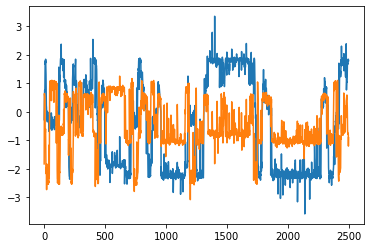

In [10]:
print(output_valid.shape)
#model.plot_factors()
tt = np.zeros(((all_time-start_time),2))
sp = np.zeros(((all_time-start_time),neuron_num))
batch_size=1
gg = int(NRep/batch_size)
import math
def mutual_info(m):
    K=10
    h_y_xw = np.zeros(neuron_num)
    h_y_x = np.zeros(neuron_num)
    T = m.shape[0]
    for n in range(neuron_num):
        for k in range(K):
            h_y_xw_tem = 0
            h_y_x_tem = 0
            for t in range(T):
                h_y_xw_tem += m[t][n]**(k)*np.exp(-m[t][n])/(math.factorial(k)) * np.log(m[t][n]**(k)*np.exp(-m[t][n])/(math.factorial(k)))
                h_y_x_tem += m[t][n]**(k)*np.exp(-m[t][n])/(math.factorial(k))
            h_y_xw[n] += h_y_xw_tem/T
            if h_y_x_tem < 1e-5:
                h_y_x_tem = 1e-5
            h_y_x[n] -= h_y_x_tem/T * math.log(h_y_x_tem/T)
            
    return  h_y_xw.sum()+h_y_x.sum()

for k in range(gg):
    t = model.infer_factors(output_valid[batch_size *k:batch_size *(k+1),:])
    #spi = model.reconstruct(output_valid[batch_size *k:batch_size *(k+1),:])
    #print(spi.shape)
    for i in range(batch_size):
        for j in range(Time):
            tt[(i+batch_size*k)*Time+j,:] = t[i][j].to('cpu').detach().numpy().copy()
            #print(model.mcdropout(output_valid[batch_size *k:batch_size *(k+1),:],np.ones(2),T=10))
            #print(mutual_info(y_hat))
            #obs_mc_mean = y_hat.mean(axis=0)
            #obs_mc_std = y_hat.std(axis=0)
            #print(poisson_entropy(np.round(obs_mc_mean)))
            #for l in range(neuron_num):
                #sp[(i+batch_size*k)*Time+j,l] = spi[j][l]
plt.figure()
plt.plot(tt)

In [ ]:
#next_state = model.transition_rnn(tt[:1,:])
#print(next_state)

## Plot results summary 

In [ ]:
# for i in range(neuron_num):
    plt.figure()
    plt.plot(y_data[:,i], linewidth = 2)
    plt.plot(sp[:,i],'r',linewidth = 1)
    plt.title(i)
    plt.ylim(-2,20)

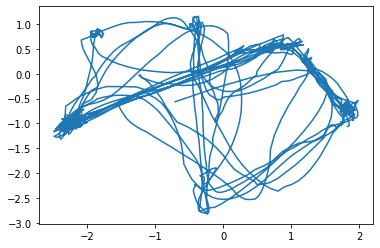

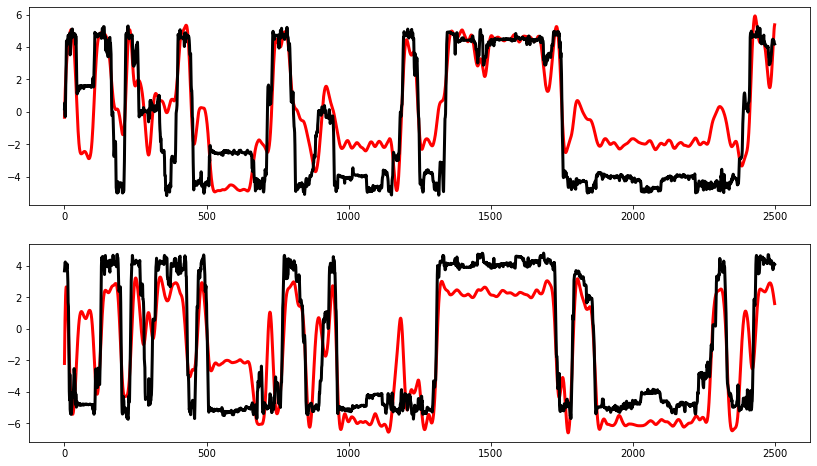

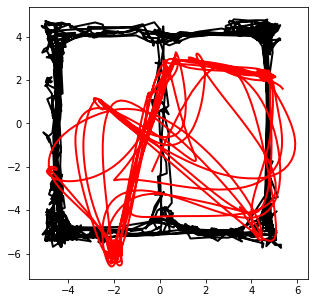

In [11]:
import funs
from scipy import signal
qz_mean_est = tt
#plt.plot(qz_mean_est[:,1])
qz_est_norm = qz_mean_est#np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
qz_est_norm[:,0] = signal.savgol_filter(qz_est_norm[:,0], 51, 5)
qz_est_norm[:,1] = signal.savgol_filter(qz_est_norm[:,1],51, 5)
plt.plot(qz_est_norm[:,0],qz_est_norm[:,1])
z_true_c = traj# - x_test.mean(axis=0)
z_true_norm = z_true_c#/np.linalg.norm(z_true_c)

R = funs.compute_optimal_rotation(np.stack(qz_est_norm), z_true_norm, scale=True)
v_state = []
v_bin = 20
#for xi in range(v_bin):
   # for yi in range(v_bin):
        #y_hat = model.mcdropout(output_valid[:batch_size,:],np.array([-8+xi*0.8,-8+yi*0.8]).dot(np.linalg.inv(R)),T=10)
        #v_state.append(mutual_info(y_hat))
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
plt.figure(figsize=(14,8))
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure(figsize=(5,5))
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[:,0], qz_est_norm_R[:,1], lw=2, color = 'r')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import grid_world

# agentの生成
agent = grid_world.Agent([0,0])

num_row = v_bin
num_col = v_bin
       
X, Y = np.mgrid[-8:-8+v_bin*0.8:16/20, -8:-8+v_bin*0.8:16/20]
print(X[1]*2)
X[1] = X[1]
z=np.zeros([v_bin,v_bin])
for i in range(v_bin):
    for j in range(v_bin):
        z[i,j] = v_state[v_bin*i+j]
fig, ax = plt.subplots()
im = ax.pcolormesh(X, Y, z, cmap='inferno',vmin=0,vmax=3)
ax.set_xlabel("X")
ax.set_ylabel("Y")
cbar = fig.colorbar(im)
cbar.set_label("Z")
plt.show()
fig.savefig("./gif/img22.png")
#grid_world.pi_arrow_plot(pi)
#grid_world.V_value_plot(V)
from PIL import Image
import glob

files = sorted(glob.glob('./gif/*.png'))  
images = list(map(lambda file : Image.open(file) , files))
images[0].save('image.gif' , save_all = True , append_images = images[1:] , duration = 200 , loop = 0)